In [3]:
SEED=42

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold
# from lofo import LOFOImportance, Dataset, plot_importance
import lightgbm as lgb
from tqdm.notebook import tqdm
import itertools
%matplotlib inline
pd.set_option('max_columns', 300)
pd.set_option('max_rows', 300)

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the time id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [4]:
train = pd.read_csv("../input/processed-book-ffill/processed_train.csv")
test = pd.read_csv("../input/processed-book-ffill/processed_test.csv")
# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# Get base score

In [6]:
params = {
    'random_state': SEED,
    'objective': 'rmse',  
    'boosting_type': 'gbdt',
#     'num_leaves': 100,
#     'learning_rate': 0.1,
#     'colsample_bytree': 0.8,
#     'subsample': 0.8,
#     'n_estimators': 1000,
    'min_child_samples': int(0.01*train.shape[0])
}
feature_cols = [c for c in train.columns if c not in ['row_id', 'target', 'time_id', 'stock_id', 'target']]
kfold = GroupKFold(n_splits=5)

In [7]:
base_cv_score = np.zeros(5, dtype=np.float32)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, groups=train.time_id)):
    print(fold)
    x_train, x_val = train.loc[trn_ind, feature_cols], train.loc[val_ind, feature_cols]
    y_train, y_val = train.loc[trn_ind, 'target'], train.loc[val_ind, 'target']
    # Root mean squared percentage error weights
    train_weights = 1 / np.square(y_train)
    val_weights = 1 / np.square(y_val)
    
    # Fit with sklearn API
    model = lgb.LGBMRegressor(**params)
    model.fit(x_train, 
              y_train, 
              sample_weight=train_weights,
              eval_set=[(x_val, y_val)],
              eval_sample_weight=[val_weights],
              eval_metric='rmse',
              early_stopping_rounds=100,
              verbose=100)
    
    base_cv_score[fold] = rmspe(y_val, model.predict(x_val))
base_cv_score

0
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.000501884
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.000501884
1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.000516356
Did not meet early stopping. Best iteration is:
[87]	valid_0's rmse: 0.000515758
2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.000480284
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.000480082
3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.000481976
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.000481747
4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.000478685
Did not meet early stopping. Best iteration is:
[87]	valid_0's rmse: 0.000478556


array([0.23146638, 0.24061646, 0.22342369, 0.22313443, 0.21904546],
      dtype=float32)

# LOFO

In [8]:
feature_groups = {
    'wap1': [c for c in feature_cols if c.split('_')[0]=='wap1'],
    'wap2': [c for c in feature_cols if c.split('_')[0]=='wap2'],
    'log_return1': [c for c in feature_cols if c.split('_')[0:2]==['log', 'return1'] and c.split('_')[-1] not in ['time', 'stock']],
    'log_return2': [c for c in feature_cols if c.split('_')[0:2]==['log', 'return2'] and c.split('_')[-1] not in ['time', 'stock']],
    'wap_balance': [c for c in feature_cols if c.split('_')[0:2]==['wap', 'balance']],
    'price_spread': [c for c in feature_cols if c.split('_')[0:2]==['price', 'spread']],
    'bid_spread': [c for c in feature_cols if c.split('_')[0:2]==['bid', 'spread']],
    'ask_spread': [c for c in feature_cols if c.split('_')[0:2]==['ask', 'spread']],
    'total_volume': [c for c in feature_cols if c.split('_')[0:2]==['total', 'volume']],
    'volume_imbalance': [c for c in feature_cols if c.split('_')[0:2]==['volume', 'imbalance']],
    'trade_log_return': [c for c in feature_cols if c.split('_')[0:3]==['trade', 'log', 'return'] and c.split('_')[-1] not in ['time', 'stock']],
    'trade_seconds_in_bucket': [c for c in feature_cols if c.split('_')[0:4]==['trade', 'seconds', 'in', 'bucket']],    
    'trade_size': [c for c in feature_cols if c.split('_')[0:2]==['trade', 'size']],
    'trade_order_count': [c for c in feature_cols if c.split('_')[0:3]==['trade', 'order', 'count']],
    'timeagg': [c for c in feature_cols if c.split('_')[-1]=='time'],
    'stockagg': [c for c in feature_cols if c.split('_')[-1]=='stock'],
}
grouped_features = list(itertools.chain.from_iterable(feature_groups.values()))
len(grouped_features), len(set(grouped_features))

(240, 240)

In [9]:
not_grouped_features = {}
for fea in feature_cols:
    if fea not in set(grouped_features):
        not_grouped_features[fea] = [fea]
not_grouped_features

{}

In [10]:
feature_groups = {**feature_groups, **not_grouped_features}

In [11]:
lofo_cv_scores = np.zeros((len(feature_groups), 5), dtype=np.float32)
for i, group_to_drop in enumerate(tqdm(feature_groups.keys())):
    lofo_cols = [c for c in feature_cols if c not in feature_groups[group_to_drop]]
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, groups=train.time_id)):
        x_train, x_val = train.loc[trn_ind, lofo_cols], train.loc[val_ind, lofo_cols]
        y_train, y_val = train.loc[trn_ind, 'target'], train.loc[val_ind, 'target']

        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)

        # Fit with sklearn API
        model = lgb.LGBMRegressor(**params)
        model.fit(x_train, 
                  y_train, 
                  sample_weight=train_weights,
                  eval_set=[(x_val, y_val)],
                  eval_sample_weight=[val_weights],
                  eval_metric='rmse',
                  early_stopping_rounds=100,
                  verbose=False)
        lofo_cv_scores[i, fold] = rmspe(y_val, model.predict(x_val))

In [12]:
# https://github.com/aerdem4/lofo-importance/blob/efbb00bf47ae329aa1fd98ec8a46aaca6841b21a/lofo/utils.py#L5
def lofo_to_df(lofo_scores, feature_list):
    importance_df = pd.DataFrame()
    importance_df["feature"] = feature_list
    importance_df["importance_mean"] = lofo_scores.mean(axis=1)
    importance_df["importance_std"] = lofo_scores.std(axis=1)

    for val_score in range(lofo_scores.shape[1]):
        importance_df["val_imp_{}".format(val_score)] = lofo_scores[:, val_score]

    return importance_df.sort_values("importance_mean", ascending=False)

# https://github.com/aerdem4/lofo-importance/blob/master/lofo/plotting.py
def plot_importance(importance_df, figsize=(8, 8), kind="default"):
    """Plot feature importance
    Parameters
    ----------
    importance_df : pandas dataframe
        Output dataframe from LOFO/FLOFO get_importance
    kind : string
        plot type can be default or box
    figsize : tuple
    """
    importance_df = importance_df.copy()
    importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
    importance_df.sort_values("importance_mean", inplace=True)

    available_kinds = {"default", "box"}
    if kind not in available_kinds:
        warnings.warn("{kind} not in {ak}. Setting to default".format(kind=kind, ak=available_kinds))

    if kind == "default":
        importance_df.plot(x="feature", y="importance_mean", xerr="importance_std",
                           kind='barh', color=importance_df["color"], figsize=figsize)
    elif kind == "box":
        lofo_score_cols = [col for col in importance_df.columns if col.startswith("val_imp")]
        features = importance_df["feature"].values.tolist()
        importance_df.set_index("feature")[lofo_score_cols].T.boxplot(column=features, vert=False, figsize=figsize)

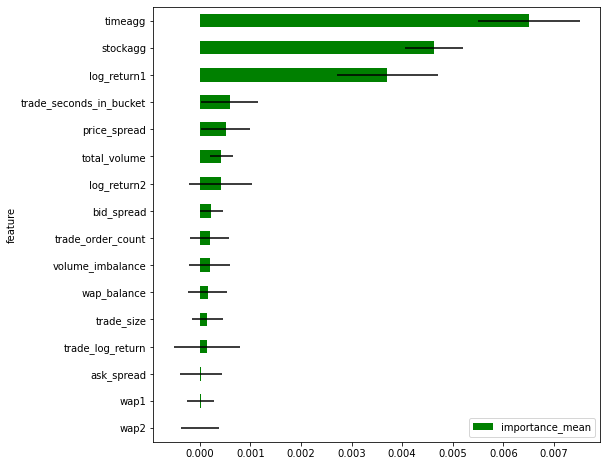

In [13]:
lofo_cv_scores_normalized = np.array([lofo_cv_score-base_cv_score for lofo_cv_score in lofo_cv_scores])
lofo_df = lofo_to_df(lofo_cv_scores_normalized, list(feature_groups.keys()))
lofo_df.to_csv("lofo_df.csv", index=False)
plot_importance(lofo_df)